In [1]:
import pandas as pd
import torch
import random 
import torch
import matplotlib.pyplot as plt
import matplotlib
import random
import numpy as np
from math import sqrt
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Подготовим данные тренировки 

In [2]:
def metric(pred, target):
    return (pred - target).abs().mean()
##############################################
def normalization(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df

In [3]:
training_whole_dataframe = pd.read_csv('/home/vasily/Data_for_JUNO/train/ProcessedTrain0.csv').head(1000000)
training_whole_dataframe['R_c_lpmt'] = np.sqrt(training_whole_dataframe['x_c_lpmt']**2 + training_whole_dataframe['y_c_lpmt']**2)
training_dataframe_prep = normalization(training_whole_dataframe[['R_c_lpmt','z_c_lpmt', 'std', 'mean']])
training_dataframe_prep['allHits_lpmt'] = training_whole_dataframe['allHits_lpmt'] / 20000

#trainig_whole_dataframe = normalization(trainig_whole_dataframe)
training_dataframe_prep.head(5)

,R_c_lpmt,z_c_lpmt,std,mean,allHits_lpmt
0,0.555357,0.764056,0.343695,0.336171,0.35140
1,0.655755,0.724471,0.492880,0.310763,0.24000
2,0.451915,0.808408,0.432159,0.351712,0.18400
3,0.473462,0.524954,0.128797,0.416096,0.70225
4,0.870647,0.631038,0.616251,0.806517,0.65990


In [4]:
#Our data to use
targets_tensor = torch.tensor(training_whole_dataframe['Edep'].values)
targets_tensor = targets_tensor / 10
#print(targets_tensor.shape)
data_tensor = torch.tensor(training_dataframe_prep.values)
#data_tensor = torch.tensor(training_dataframe_prep[['R_c_lpmt', 'z_c_lpmt', 'std', 'mean']].values)
#data_tensor = normalization(data_tensor)

In [5]:
# Choose examples for training.
training_examples = data_tensor[:900000]
training_targets = targets_tensor[:900000]
# Choose examples for validation.
validation_examples = data_tensor[900000:1000000]
validation_targets = targets_tensor[900000:1000000]
#Unsqueeze our tensors
training_examples.reshape(-1,5)
training_targets.unsqueeze_(1)
validation_examples.reshape(-1,5)
validation_targets.unsqueeze_(1)
# Double-check that we've done the right thing.
print(training_examples.shape, training_targets.shape, validation_examples.shape, validation_targets.shape) 

torch.Size([900000, 5]) torch.Size([900000, 1]) torch.Size([100000, 5]) torch.Size([100000, 1])


# Определяем структуру нейронной сети

In [6]:
loss = torch.nn.MSELoss()
class RegressionNet(torch.nn.Module): #так обозначается наследование

# Проверка осуществляется вызовом кода:
    def metric(pred, target):
        return loss(pred, target)#(pred - target).abs().mean()


    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(5,n_hidden_neurons)#это атрибуты класса 
        self.act1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_hidden_neurons,n_hidden_neurons)
        self.act2 = torch.nn.Tanh()
        self.fc3 = torch.nn.Linear(n_hidden_neurons,1)
        #self.act3 = torch.nn.Tanh()
        #self.fc4 = torch.nn.Linear(n_hidden_neurons,1)
        
        
    def forward(self, x):
        x = self.fc1(x.float())
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        #x = self.act3(x)
        #x = self.fc4(x)
        return x
      
net = RegressionNet(20)

In [7]:
def loss_pred(pred, target):
    squares = (pred - target)**2
    return sqrt(squares.mean())/pred.mean()

def predict(net, predicted_data, test_targers):
    pred = net.forward(predicted_data)
    #loss = torch.nn.MSELoss()
    output = loss_pred(pred, test_targers)
    print("Mean Squared Error / Average predicted value = ",float(output))
  #plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
  #plt.plot(x_train.numpy(), y_train.numpy(), '^',c = 'y', label='Train')
  #plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Predic')
  #plt.legend(loc='upper left')
  #plt.xlabel('$x$')
  #lt.ylabel('$y$')
    return pred

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005) # теперь оптимайзер как бы завязан на нейронную сеть (объект класса торч.нн.модуль)
batch_size = 100

def loss(pred, target):
    squares = (pred - target)**2
    return squares.mean()


# Непосредственно обучение

In [8]:
for epoch_index in range(1500):
    order = np.random.permutation(len(training_examples))
    for start_index in range(0, len(training_examples), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        
        training_examples_batch = training_examples[batch_indexes]#.to(device)
        training_targets_batch = training_targets[batch_indexes]#.to(device)
        
        preds = net.forward(training_examples_batch) 
        
        loss_value = loss(preds, training_targets_batch)
        loss_value.backward()
        
        optimizer.step()
    if((epoch_index % 50) == 0):    
        validation_preds = net.forward(validation_examples) 
        print(metric(net.forward(validation_examples), validation_targets).item()) 
    #predict(net,training_examples,training_preds,training_targets)       


0.008655268180564047


KeyboardInterrupt: 

# Проверяем на тестовых данных

Energy is 0MeV
Mean Squared Error / Average predicted value =  0.12235146015882492
Gaussian parameters: mu = 1.1101692, sigma = 0.10386015


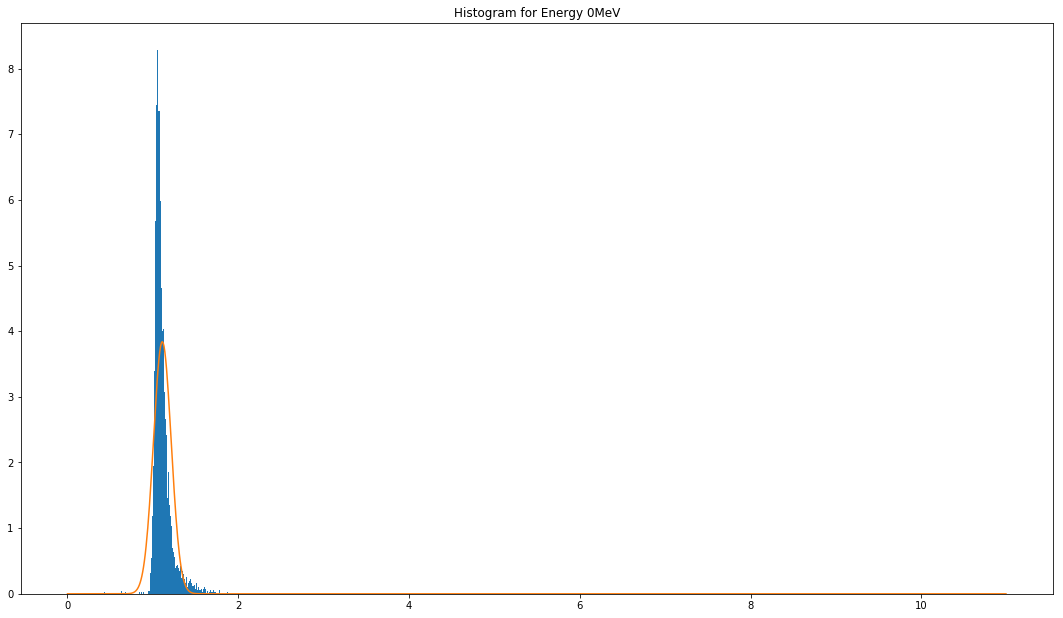

Energy is 1MeV
Mean Squared Error / Average predicted value =  0.05476781353354454
Gaussian parameters: mu = 2.0513527, sigma = 0.10834234


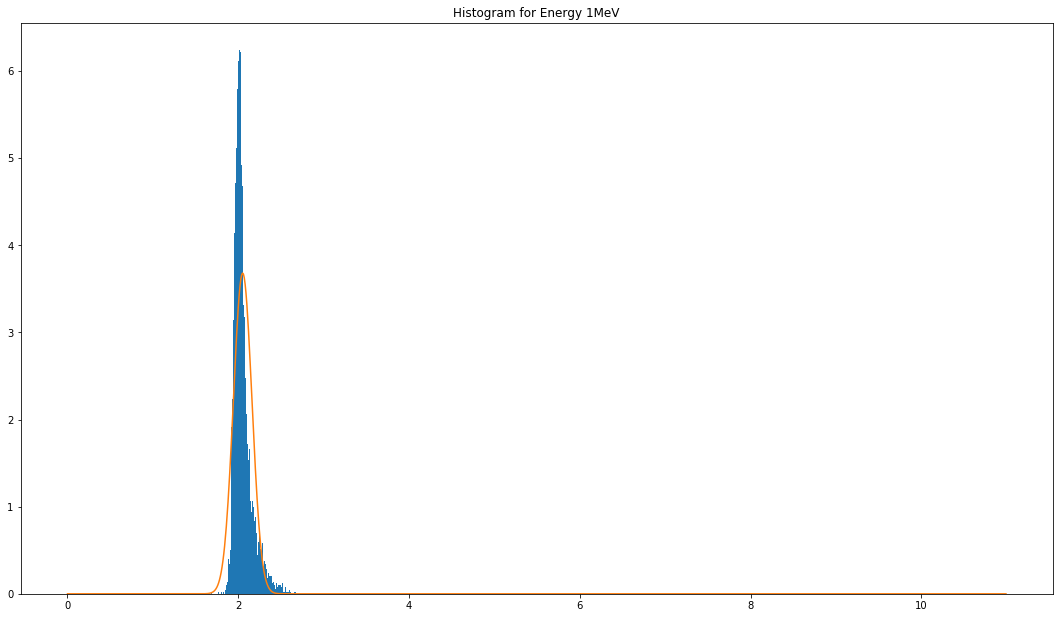

Energy is 2MeV
Mean Squared Error / Average predicted value =  0.03491232544183731
Gaussian parameters: mu = 2.9920468, sigma = 0.09940026


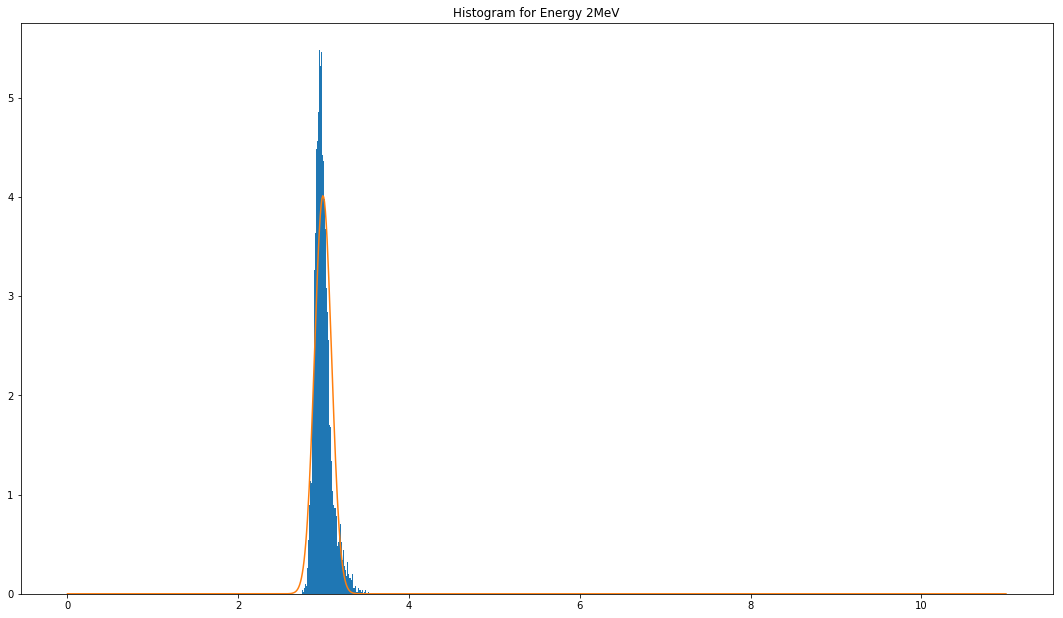

Energy is 3MeV
Mean Squared Error / Average predicted value =  0.03222397342324257
Gaussian parameters: mu = 3.9346595, sigma = 0.09210662


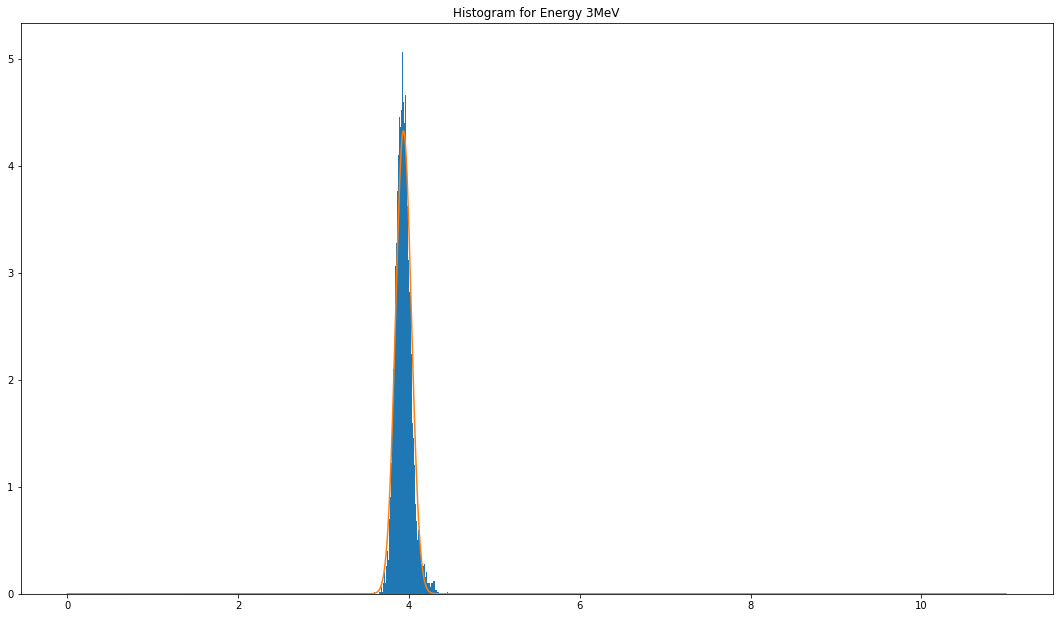

Energy is 4MeV
Mean Squared Error / Average predicted value =  0.021121861413121223
Gaussian parameters: mu = 4.9730854, sigma = 0.11367697


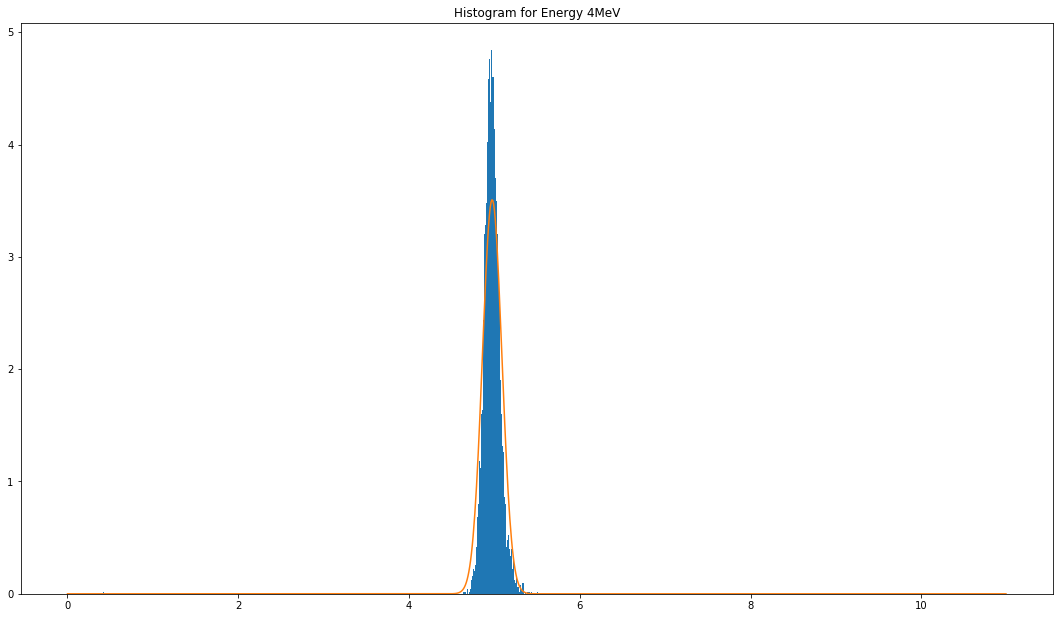

Energy is 5MeV
Mean Squared Error / Average predicted value =  0.03762540966272354
Gaussian parameters: mu = 5.837009, sigma = 0.12426221


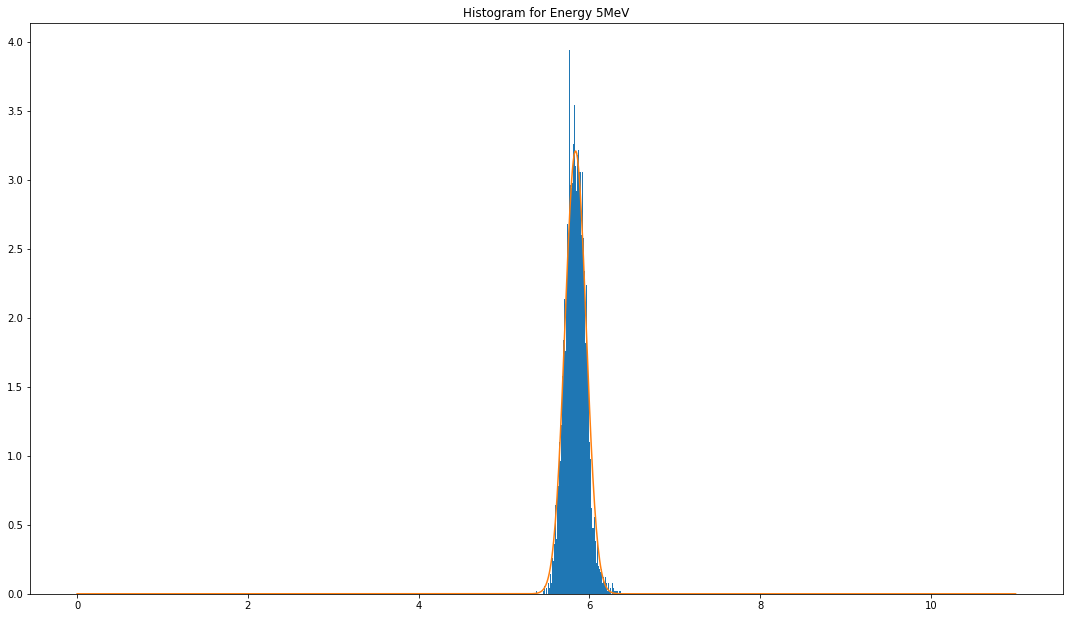

Energy is 6MeV
Mean Squared Error / Average predicted value =  0.04261886328458786
Gaussian parameters: mu = 6.7675595, sigma = 0.13760574


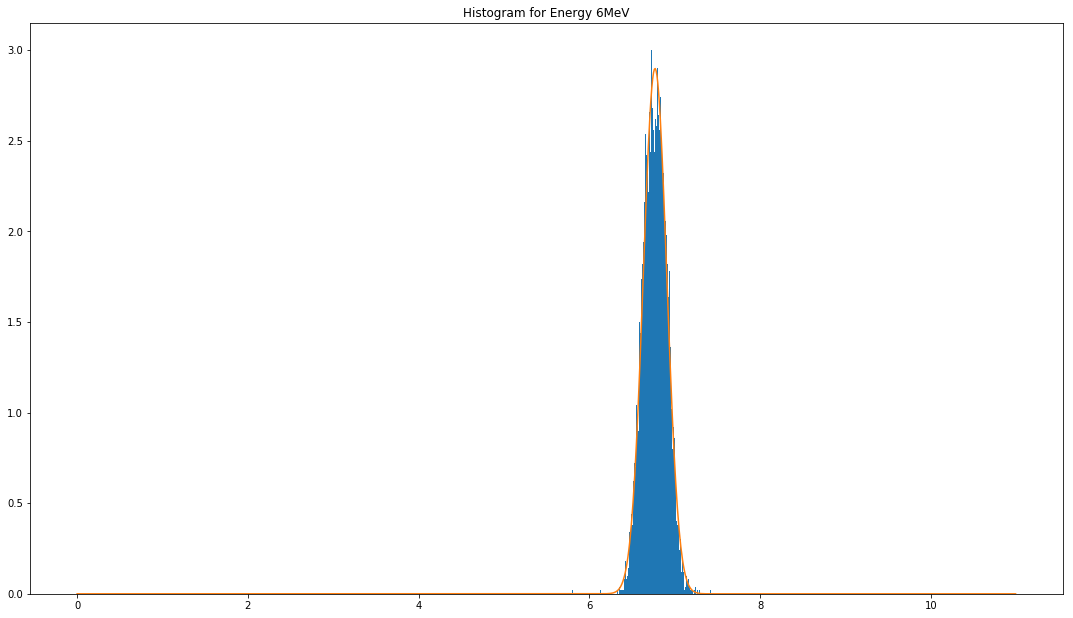

Energy is 7MeV
Mean Squared Error / Average predicted value =  0.04395441338419914
Gaussian parameters: mu = 7.720484, sigma = 0.16973954


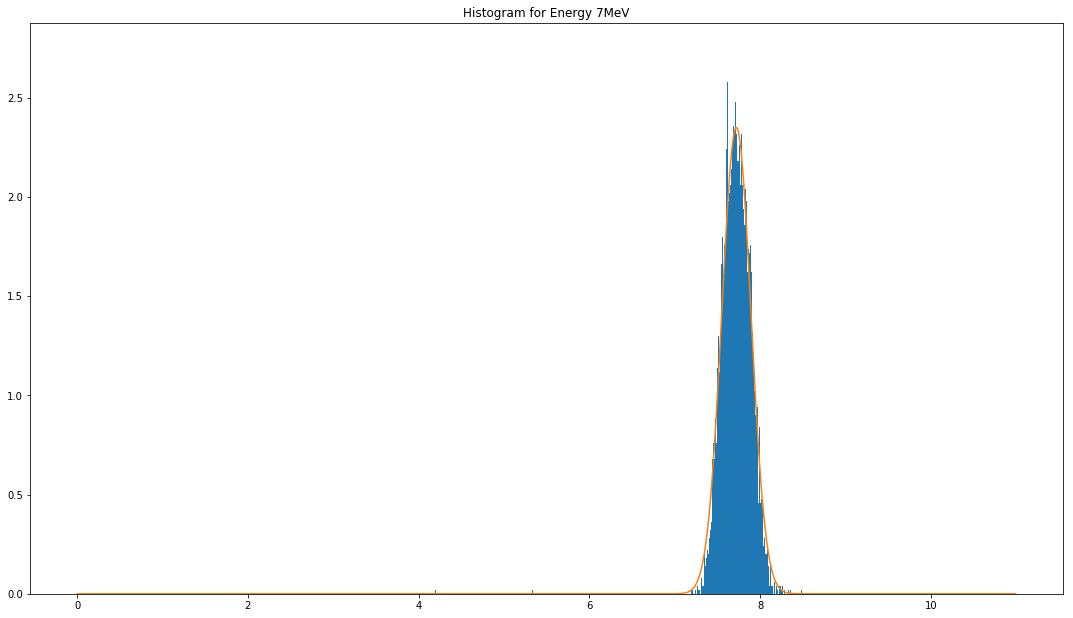

Energy is 8MeV
Mean Squared Error / Average predicted value =  0.04950043559074402
Gaussian parameters: mu = 8.630516, sigma = 0.17526226


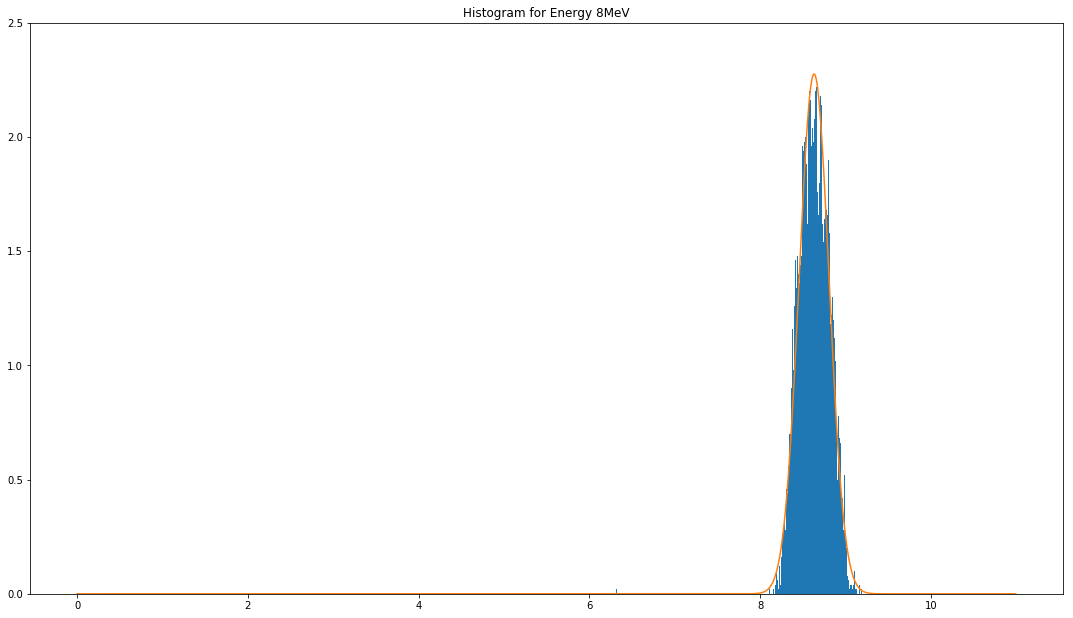

Energy is 9MeV
Mean Squared Error / Average predicted value =  0.05153026804327965
Gaussian parameters: mu = 9.545031, sigma = 0.2915598


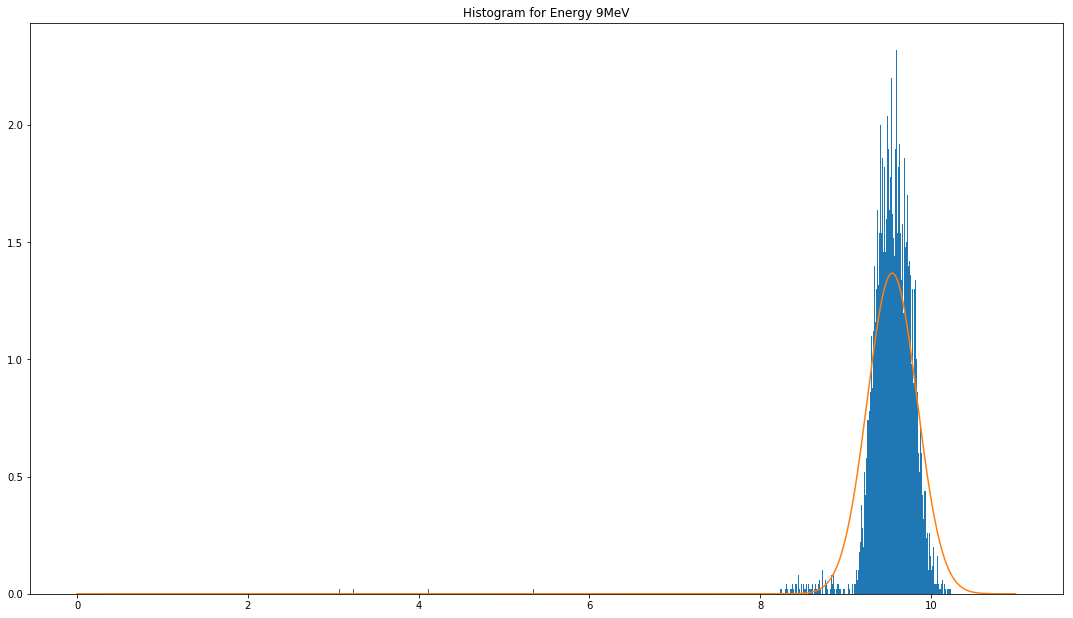

Energy is 10MeV
Mean Squared Error / Average predicted value =  0.06001269817352295
Gaussian parameters: mu = 10.425424, sigma = 0.29805556


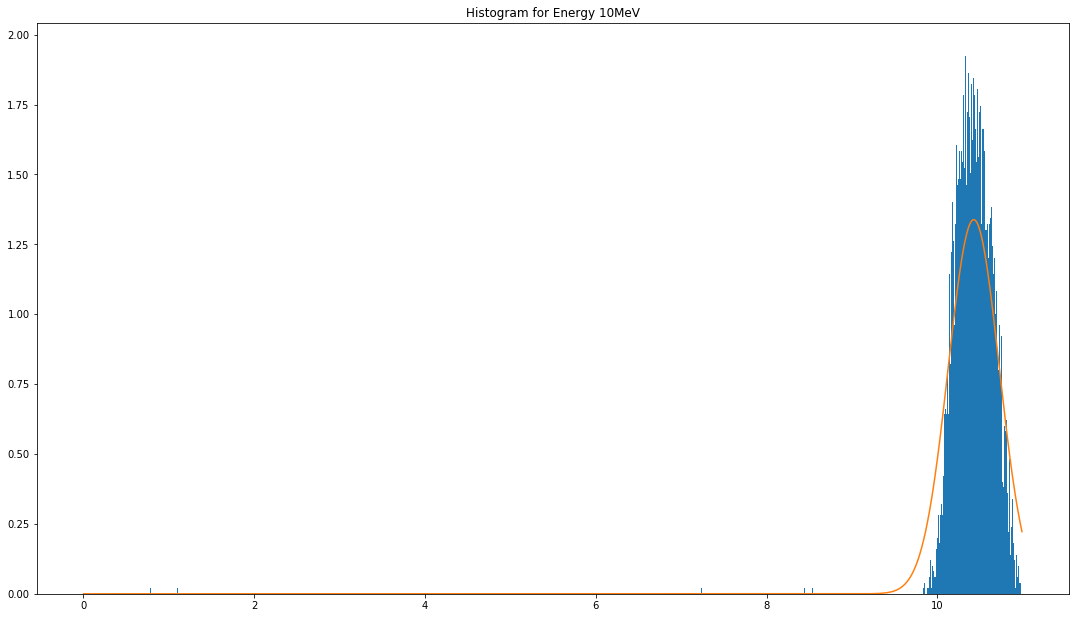

In [9]:
#predict(net, predicted_data, predicted_targets, test_targers)
for i in range(11):
    print("Energy is " + str(i) + "MeV")
    a = '/home/vasily/Data_for_JUNO/test/ProcessedTest' + str(i) + '.csv'    
    testing_whole_dataframe = pd.read_csv(a).head(5000)
    testing_whole_dataframe['R_c_lpmt'] = np.sqrt(testing_whole_dataframe['x_c_lpmt']**2 + testing_whole_dataframe['y_c_lpmt']**2)
    testing_dataframe_prep = normalization(testing_whole_dataframe[['R_c_lpmt','z_c_lpmt', 'std', 'mean']])
    testing_dataframe_prep['allHits_lpmt'] = testing_whole_dataframe['allHits_lpmt'] / 20000
    targets_tensor_test = torch.tensor(testing_whole_dataframe['Edep'].values) / 10 
    #targets_tensor_test = targets_tensor_test / 10
    
    data_tensor_test = torch.tensor(testing_dataframe_prep.values)
    #data_tensor_test = torch.tensor(testing_dataframe_prep[['R_c_lpmt','z_c_lpmt', 'std', 'mean']].values)
    data_tensor_test.reshape(-1,5)
    #data_tensor_test = normalization(data_tensor_test)
    targets_tensor_test.unsqueeze_(1) 
    prediction = 10* predict(net, data_tensor_test, targets_tensor_test).detach().numpy()
    
    #строим гистограмму
    plt.hist(prediction, bins = [i*0.01 for i in range(1100)],normed=True) 
    plt.title("Histogram for Energy " + str(i) + "MeV") 
    
    #фитируем распределением Гаусса
    mean,std=norm.fit(prediction)
    x = [i*0.01 for i in range(1100)]
    y = norm.pdf(x, mean, std)
    print("Gaussian parameters: mu = " + str(mean) + ", sigma = " + str(std))
    
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    #fig.savefig('test'+ str(i)+'png.png', dpi=100)
    plt.plot(x, y)
    plt.show()

# Черновики и всякие проверки

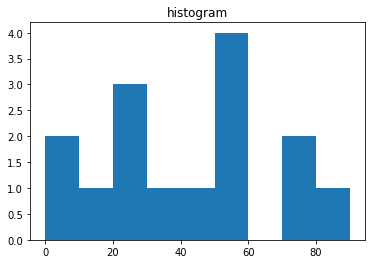

In [57]:
a = np.array([22,87,5,43,56,73,55,54,11,20,51,5,79,31,27]) 
plt.hist(a, bins = [i*10 for i in range(10)]) 
plt.title("histogram") 
plt.show()
Gaussian parameters: mu = 1.1101692, sigma = 0.10386015


In [70]:
a = np.array([22,87,5,43,56,73,55,54,11,20,51,5,79,31,27]) 
np.histogram(a,bins = [0,20,40,60,80,100]) 
hist,bins = np.histogram(a,bins = [0,20,40,60,80,100]) 
print (hist)
print (bins)

[3 4 5 2 1]
[  0  20  40  60  80 100]


In [34]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

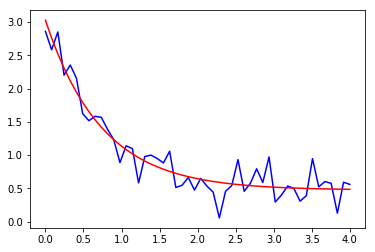

In [71]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, ydata, 'b-', label='data')
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
data = np.random.normal(loc=5.0, scale=2.0, size=1000)
mean,std=norm.fit(data)
data

array([ 5.65122424,  5.82036221,  3.58004539,  3.62154549,  3.72633416,
        4.61350295,  5.88643708,  8.76891935,  2.26955972,  2.61271108,
        7.50621461,  4.72887612,  1.63794812,  3.34951373,  4.45960149,
        5.4780657 ,  4.38942503,  6.42041815,  6.16549728,  2.55065127,
        2.1346374 ,  4.30600624,  8.32702228,  6.48266318,  6.74000038,
        3.17205284,  1.97597572,  5.49100108,  4.25557506,  2.18812722,
        2.99960665,  5.33904184,  4.94952937,  4.47305476,  4.58669192,
        6.549977  ,  6.48211596,  7.64945499,  1.82979769,  9.53110384,
        7.4036904 ,  5.59208944,  3.98159029,  6.4960642 ,  3.54504106,
       -1.11728769,  5.77366344,  4.8209708 ,  4.2448847 ,  4.86957796,
        6.87168659, -1.14637382,  4.46592312,  7.77398999,  4.5434193 ,
        6.81234967,  7.22166302,  5.78381713,  4.63170439,  6.76197861,
        7.54644556,  5.62931304,  4.59785244,  6.30813519,  6.0750932 ,
        5.60885238,  4.25812688,  5.55996792,  6.41910009,  3.27

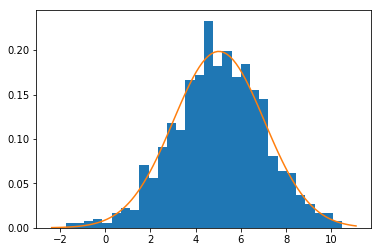

In [3]:
plt.hist(data, bins=30, normed=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()